### Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sklearn
import torch
import torchvision.transforms as transforms

### Load the dataset into dataframe

In [26]:
# Load the metadata (labels)
metadata_path = "../HAM10000/GroundTruth.csv"
metadata = pd.read_csv(metadata_path)
classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
print("Metadata Shape:", metadata.shape)
metadata["label"] = metadata[classes].idxmax(axis=1)
print("\nFirst few rows of metadata:")
print(metadata.head())

Metadata Shape: (10015, 8)

First few rows of metadata:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL


In [27]:
class_counts = metadata[classes].sum()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64


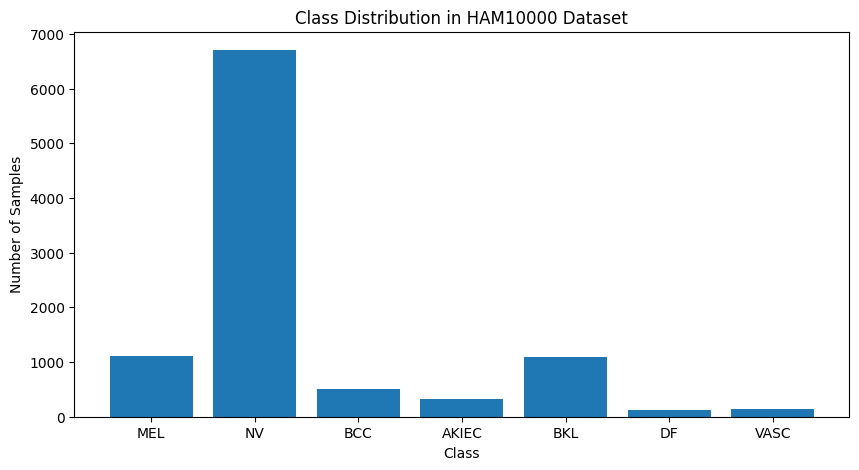

In [28]:
# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values)
plt.title("Class Distribution in HAM10000 Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

### TRAIN / TEST / VALIDATION SPLIT

In [29]:
# Split into train and test+val (70% train, 30% test+val)
from sklearn.model_selection import train_test_split


train_data, test_val_data = train_test_split(
    metadata,
    test_size=0.3,
    random_state=42,
    stratify=metadata["label"]
)

# Split test+val into test and val (15% test, 15% val)
test_data, val_data = train_test_split(
    test_val_data,
    test_size=0.5,  # 0.5 of 30% = 15% of total
    random_state=42,
    stratify=test_val_data["label"]
)

# Print the sizes of each split
print("\nDataset Split Sizes:")
print(f"Training set: {len(train_data)} samples ({len(train_data)/len(metadata)*100:.1f}%)")
print(f"Validation set: {len(val_data)} samples ({len(val_data)/len(metadata)*100:.1f}%)")
print(f"Test set: {len(test_data)} samples ({len(test_data)/len(metadata)*100:.1f}%)")

# Check class distribution in each split
print("\nClass Distribution in Training Set:")
print(train_data["label"].value_counts())
print(train_data.head())
print("\nClass Distribution in Validation Set:")
print(val_data["label"].value_counts())
print(val_data.head())
print("\nClass Distribution in Test Set:")
print(test_data["label"].value_counts())
print(test_data.head())


Dataset Split Sizes:
Training set: 7010 samples (70.0%)
Validation set: 1503 samples (15.0%)
Test set: 1502 samples (15.0%)

Class Distribution in Training Set:
label
NV       4693
MEL       779
BKL       769
BCC       360
AKIEC     229
VASC       99
DF         81
Name: count, dtype: int64
             image  MEL   NV  BCC  AKIEC  BKL   DF  VASC label
2017  ISIC_0026323  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
6298  ISIC_0030604  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL
9749  ISIC_0034055  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
7732  ISIC_0032038  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
17    ISIC_0024323  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL

Class Distribution in Validation Set:
label
NV       1006
MEL       167
BKL       165
BCC        77
AKIEC      49
VASC       22
DF         17
Name: count, dtype: int64
             image  MEL   NV  BCC  AKIEC  BKL   DF  VASC label
4896  ISIC_0029202  0.0  0.0  0.0    0.0  1.0  0.0   0.0   BKL
8618  ISIC_0032924  0.0  1.0  0.0  

### Create empty folder

In [30]:
import os
import shutil

# Define the classes
classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# Define the base paths
base_image_path = "../HAM10000/images/"
base_mask_path = "../HAM10000/masks/"

# Define the splits
splits = ["train", "val", "test"]

# Create the new folder structure
for split in splits:
    for class_name in classes:
        # Create image folders (e.g., images/train/MEL/)
        image_split_class_path = os.path.join(base_image_path, split, class_name)
        os.makedirs(image_split_class_path, exist_ok=True)
        
        # Create mask folders (e.g., masks/train/MEL/)
        mask_split_class_path = os.path.join(base_mask_path, split, class_name)
        os.makedirs(mask_split_class_path, exist_ok=True)

print("Folder structure created successfully.")

Folder structure created successfully.


### SPLIT DATA INTO SPECIFIC FOLDERS

In [31]:
# Function to move files for a given split
def move_files(data, split_name):
    for _, row in data.iterrows():
        image_id = row["image"]
        label = row["label"]
        
        # Source paths
        src_image_path = f"../HAM10000/images/{image_id}.jpg"
        src_mask_path = f"../HAM10000/masks/{image_id}_segmentation.png"
        
        # Destination paths
        dst_image_path = f"../HAM10000/images/{split_name}/{label}/{image_id}.jpg"
        dst_mask_path = f"../HAM10000/masks/{split_name}/{label}/{image_id}_segmentation.png"
        
        # Move files (copy then delete to be safe)
        if os.path.exists(src_image_path) and os.path.exists(src_mask_path):
            shutil.copy2(src_image_path, dst_image_path)
            shutil.copy2(src_mask_path, dst_mask_path)
            os.remove(src_image_path)  # Remove the original file
            os.remove(src_mask_path)
        else:
            print(f"Missing file for {image_id} in {split_name} split")

# Move files for each split
move_files(train_data, "train")
move_files(val_data, "val")
move_files(test_data, "test")

print("Files moved successfully.")

Missing file for ISIC_0026323 in train split
Missing file for ISIC_0030604 in train split
Missing file for ISIC_0034055 in train split
Missing file for ISIC_0032038 in train split
Missing file for ISIC_0024323 in train split
Missing file for ISIC_0025228 in train split
Missing file for ISIC_0027188 in train split
Missing file for ISIC_0028656 in train split
Missing file for ISIC_0034173 in train split
Missing file for ISIC_0026659 in train split
Missing file for ISIC_0025423 in train split
Missing file for ISIC_0029971 in train split
Missing file for ISIC_0032974 in train split
Missing file for ISIC_0031126 in train split
Missing file for ISIC_0029178 in train split
Missing file for ISIC_0025002 in train split
Missing file for ISIC_0032242 in train split
Missing file for ISIC_0033503 in train split
Missing file for ISIC_0026258 in train split
Missing file for ISIC_0031053 in train split
Missing file for ISIC_0029563 in train split
Missing file for ISIC_0024959 in train split
Missing fi

In [32]:
import os

def check_image_mask_pairs(data, split_name, classes):
    base_image_path = f"../HAM10000/images/{split_name}/"
    base_mask_path = f"../HAM10000/masks/{split_name}/"
    removed_count = 0
    
    for _, row in data.iterrows():
        image_id = row["image"]
        label = row["label"]
        
        # Paths for image and mask
        image_path = os.path.join(base_image_path, label, f"{image_id}.jpg")
        mask_path = os.path.join(base_mask_path, label, f"{image_id}_segmentation.png")
        
        # Check if both files exist
        has_image = os.path.exists(image_path)
        has_mask = os.path.exists(mask_path)
        
        if not (has_image and has_mask):
            # Delete the existing file (if any)
            if has_image:
                os.remove(image_path)
                print(f"Removed {image_path} (missing mask)")
            if has_mask:
                os.remove(mask_path)
                print(f"Removed {mask_path} (missing image)")
            removed_count += 1
    
    print(f"Removed {removed_count} incomplete image/mask pairs from {split_name} split.")

# Run for each split
check_image_mask_pairs(train_data, "train", classes)
check_image_mask_pairs(val_data, "val", classes)
check_image_mask_pairs(test_data, "test", classes)

Removed 0 incomplete image/mask pairs from train split.
Removed 0 incomplete image/mask pairs from val split.
Removed 0 incomplete image/mask pairs from test split.


### Data Precoessing

In [33]:
import cv2
import os

# Define the splits and classes
splits = ["train", "val", "test"]
classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# Base paths
base_image_path = "../HAM10000/images/"
base_mask_path = "../HAM10000/masks/"

# Check for corrupt files and remove them
for split in splits:
    for class_name in classes:
        image_dir = os.path.join(base_image_path, split, class_name)
        mask_dir = os.path.join(base_mask_path, split, class_name)
        
        image_files = os.listdir(image_dir)
        mask_files = os.listdir(mask_dir)
        
        print(f"\nChecking {split}/{class_name}...")
        print(f"Initial: {len(image_files)} images, {len(mask_files)} masks")
        
        # Check each image
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            mask_file = image_file.replace(".jpg", "_segmentation.png")
            mask_path = os.path.join(mask_dir, mask_file)
            
            # Load image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Check if either file is corrupt or missing
            if image is None or mask is None or mask_file not in mask_files:
                print(f"Corrupt or missing pair: {image_file} in {split}/{class_name}")
                if os.path.exists(image_path):
                    os.remove(image_path)
                if os.path.exists(mask_path):
                    os.remove(mask_path)
        
        # Recount after removal
        image_files = os.listdir(image_dir)
        mask_files = os.listdir(mask_dir)
        print(f"After cleanup: {len(image_files)} images, {len(mask_files)} masks")
        
        # Final check for mismatch
        if len(image_files) != len(mask_files):
            print(f"Warning: Mismatch in {split}/{class_name} after cleanup")


Checking train/MEL...
Initial: 779 images, 779 masks
After cleanup: 779 images, 779 masks

Checking train/NV...
Initial: 4693 images, 4693 masks
After cleanup: 4693 images, 4693 masks

Checking train/BCC...
Initial: 360 images, 360 masks
After cleanup: 360 images, 360 masks

Checking train/AKIEC...
Initial: 229 images, 229 masks
After cleanup: 229 images, 229 masks

Checking train/BKL...
Initial: 769 images, 769 masks
After cleanup: 769 images, 769 masks

Checking train/DF...
Initial: 81 images, 81 masks
After cleanup: 81 images, 81 masks

Checking train/VASC...
Initial: 99 images, 99 masks
After cleanup: 99 images, 99 masks

Checking val/MEL...
Initial: 167 images, 167 masks
After cleanup: 167 images, 167 masks

Checking val/NV...
Initial: 1006 images, 1006 masks
After cleanup: 1006 images, 1006 masks

Checking val/BCC...
Initial: 77 images, 77 masks
After cleanup: 77 images, 77 masks

Checking val/AKIEC...
Initial: 49 images, 49 masks
After cleanup: 49 images, 49 masks

Checking val

In [34]:
train_ids = set(train_data["image"])
val_ids = set(val_data["image"])
test_ids = set(test_data["image"])

print("Train-Val overlap:", len(train_ids & val_ids))
print("Train-Test overlap:", len(train_ids & test_ids))
print("Val-Test overlap:", len(val_ids & test_ids))

Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0


# Classification Model

In [35]:
import torchvision.transforms as transforms

# Define image size (e.g., 224x224, common for CNNs like ResNet)
IMG_SIZE = (224, 224)

# Define transformations for images
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),  # Data augmentation for training
    transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for masks (resize only, no normalization)
mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [36]:
from torch.utils.data import Dataset
import cv2
import os

class SkinCancerDataset(Dataset):
    def __init__(self, split, transform=None, mask_transform=None):
        self.split = split  # 'train', 'val', or 'test'
        self.transform = transform
        self.mask_transform = mask_transform
        self.classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            image_dir = f"../HAM10000/images/{split}/{class_name}/"
            for image_file in os.listdir(image_dir):
                self.image_paths.append(os.path.join(image_dir, image_file))
                self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Load mask
        mask_path = image_path.replace("images", "masks").replace(".jpg", "_segmentation.png")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0).float()  # Ensure mask is binary (0 or 1)
        
        label = self.labels[idx]
        return image, mask, label

# Create datasets
train_dataset = SkinCancerDataset("train", transform=train_transforms, mask_transform=mask_transforms)
val_dataset = SkinCancerDataset("val", transform=val_test_transforms, mask_transform=mask_transforms)
test_dataset = SkinCancerDataset("test", transform=val_test_transforms, mask_transform=mask_transforms)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7010
Validation dataset size: 1503
Test dataset size: 1502


In [37]:
from torch.utils.data import DataLoader
import time

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders with num_workers=0 to avoid multiprocessing issues
start_time = time.time()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print(f"Train loader creation took {time.time() - start_time:.2f} seconds")

start_time = time.time()
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Val loader creation took {time.time() - start_time:.2f} seconds")

start_time = time.time()
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Test loader creation took {time.time() - start_time:.2f} seconds")

# Verify a batch
start_time = time.time()
images, masks, labels = next(iter(train_loader))
print(f"Loading first batch took {time.time() - start_time:.2f} seconds")
print(f"Batch shapes - Images: {images.shape}, Masks: {masks.shape}, Labels: {labels.shape}")

Train loader creation took 0.00 seconds
Val loader creation took 0.00 seconds
Test loader creation took 0.00 seconds
Loading first batch took 0.23 seconds
Batch shapes - Images: torch.Size([32, 3, 224, 224]), Masks: torch.Size([32, 1, 224, 224]), Labels: torch.Size([32])


In [38]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [39]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 7 classes
num_classes = len(classes)  # 7 classes: MEL, NV, BCC, AKIEC, BKL, DF, VASC
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 11180103


C:\Users\samir\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\samir\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Compute class weights based on training set
class_counts = {}
for label in train_dataset.labels:
    class_counts[label] = class_counts.get(label, 0) + 1

total_samples = len(train_dataset)
class_weights = [total_samples / (len(classes) * class_counts[i]) for i in range(len(classes))]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: [1.285530900421786, 0.21338772031292808, 2.7817460317460316, 4.37305053025577, 1.3022478172023035, 12.36331569664903, 10.115440115440116]


Epoch [1/5] - Train Loss: 1.5934, Val Acc: 52.63%
Epoch [2/5] - Train Loss: 1.2628, Val Acc: 58.68%
Epoch [3/5] - Train Loss: 1.1549, Val Acc: 64.07%
Epoch [4/5] - Train Loss: 1.0952, Val Acc: 57.15%
Epoch [5/5] - Train Loss: 1.0691, Val Acc: 62.48%


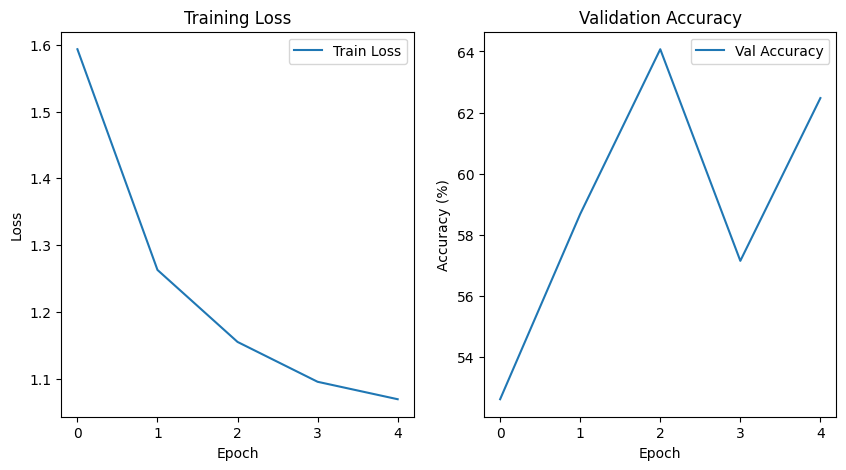

In [41]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop (first phase: train only the final layer)
num_epochs = 5
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _, labels in train_loader:  # Ignore masks for classification
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, _, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Fine-Tune Epoch [1/5] - Train Loss: 0.9662, Val Acc: 72.65%
Fine-Tune Epoch [2/5] - Train Loss: 0.6739, Val Acc: 73.12%
Fine-Tune Epoch [3/5] - Train Loss: 0.5041, Val Acc: 74.18%
Fine-Tune Epoch [4/5] - Train Loss: 0.3885, Val Acc: 78.71%
Fine-Tune Epoch [5/5] - Train Loss: 0.3379, Val Acc: 74.78%


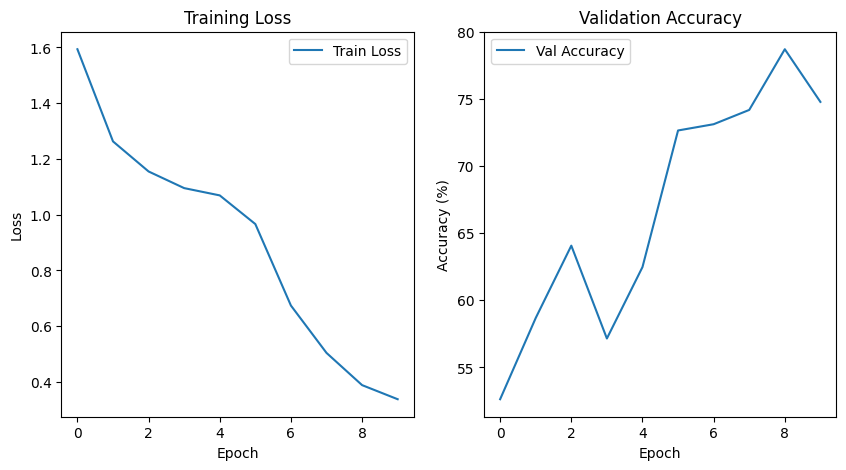

In [42]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train for a few more epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, _, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    
    print(f"Fine-Tune Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot updated curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Test Accuracy: 73.44%


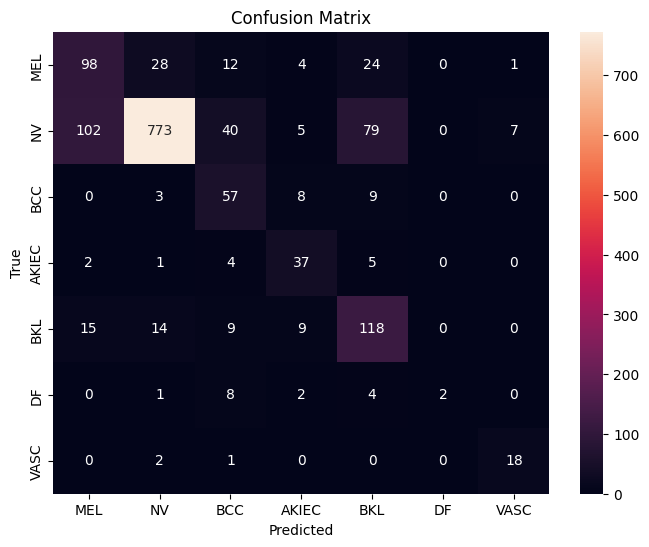


Classification Report:
              precision    recall  f1-score   support

         MEL       0.45      0.59      0.51       167
          NV       0.94      0.77      0.85      1006
         BCC       0.44      0.74      0.55        77
       AKIEC       0.57      0.76      0.65        49
         BKL       0.49      0.72      0.58       165
          DF       1.00      0.12      0.21        17
        VASC       0.69      0.86      0.77        21

    accuracy                           0.73      1502
   macro avg       0.65      0.65      0.59      1502
weighted avg       0.80      0.73      0.75      1502



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, _, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Per-class metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Segmentation

In [19]:

# Segmentation
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np

# Print current working directory for debugging
print("Current working directory:", os.getcwd())

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define base directories
base_image_dir = "../HAM10000/images"
base_mask_dir = "../HAM10000/masks"

# Define transformations (aligned with classification)
IMG_SIZE = (224, 224)

image_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Define segmentation dataset
class HAM10000SegmentDataset(Dataset):
    def __init__(self, split, base_image_dir, base_mask_dir, image_transform=None, mask_transform=None):
        self.split = split  # 'train', 'val', or 'test'
        self.base_image_dir = base_image_dir
        self.base_mask_dir = base_mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        # Directory for this split
        split_image_dir = os.path.join(base_image_dir, split)
        
        # Recursively find all .jpg files in the split folder (including class subfolders)
        self.image_paths = []
        for root, _, files in os.walk(split_image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))
        self.image_paths.sort()  # Ensure consistent ordering
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Get image path
        img_path = self.image_paths[idx]  # e.g., '../HAM10000/images/train/AKIEC/ISIC_0024306.jpg'
        img_filename = os.path.basename(img_path)  # e.g., 'ISIC_0024306.jpg'
        img_id = os.path.splitext(img_filename)[0]  # e.g., 'ISIC_0024306'
        
        # Construct mask path by replacing base_image_dir with base_mask_dir
        relative_path = os.path.relpath(img_path, self.base_image_dir)  # e.g., 'train/AKIEC/ISIC_0024306.jpg'
        mask_relative_path = relative_path.replace('.jpg', '_segmentation.png').replace('.jpeg', '_segmentation.png')
        mask_path = os.path.join(self.base_mask_dir, mask_relative_path)  # e.g., '../HAM10000/masks/train/AKIEC/ISIC_0024306_segmentation.png'
        
        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Single-channel mask
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask from [0, 1] (after ToTensor) to [0, 1] binary
        mask = (mask > 0.5).float()  # Threshold at 0.5 for binary masks
        
        return image, mask

# Create datasets for each split
train_dataset = HAM10000SegmentDataset('train', base_image_dir, base_mask_dir, image_transforms, mask_transforms)
val_dataset = HAM10000SegmentDataset('val', base_image_dir, base_mask_dir, image_transforms, mask_transforms)
test_dataset = HAM10000SegmentDataset('test', base_image_dir, base_mask_dir, image_transforms, mask_transforms)

# Debug: Check the number of files in each split
print(f"Train folder: {os.path.join(base_image_dir, 'train')}")
print(f"Number of image files in train: {len(train_dataset.image_paths)}")
print(f"Val folder: {os.path.join(base_image_dir, 'val')}")
print(f"Number of image files in val: {len(val_dataset.image_paths)}")
print(f"Test folder: {os.path.join(base_image_dir, 'test')}")
print(f"Number of image files in test: {len(test_dataset.image_paths)}")

# If train folder is empty, list the parent directory
if len(train_dataset.image_paths) == 0:
    print(f"Listing contents of parent dir {base_image_dir}:")
    print(os.listdir(base_image_dir))

# Check if datasets are empty
if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
    raise ValueError("One or more datasets are empty. Check the folder paths and file extensions.")

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Define U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):  # 1 for binary segmentation
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Middle
        self.middle = conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        # Output layer
        self.final = nn.Conv2d(64, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Middle
        m = self.middle(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(m)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.final(d1)
        return out



Current working directory: c:\Users\samir\OneDrive\Desktop\SkinCancerPattern
Using device: cuda
Train folder: ../HAM10000/images\train
Number of image files in train: 7010
Val folder: ../HAM10000/images\val
Number of image files in val: 1503
Test folder: ../HAM10000/images\test
Number of image files in test: 1502
Train samples: 7010, Val samples: 1503, Test samples: 1502


Total parameters: 31,043,521
Epoch 1/10, Train Loss: 0.2686, Val Loss: 0.2886, Val IoU: 0.6890, Val Dice: 0.7882
Epoch 2/10, Train Loss: 0.1953, Val Loss: 0.1833, Val IoU: 0.7849, Val Dice: 0.8669
Epoch 3/10, Train Loss: 0.1670, Val Loss: 0.1502, Val IoU: 0.8109, Val Dice: 0.8829
Epoch 4/10, Train Loss: 0.1533, Val Loss: 0.1540, Val IoU: 0.7897, Val Dice: 0.8720
Epoch 5/10, Train Loss: 0.1426, Val Loss: 0.1186, Val IoU: 0.8419, Val Dice: 0.9056
Epoch 6/10, Train Loss: 0.1345, Val Loss: 0.1140, Val IoU: 0.8458, Val Dice: 0.9080
Epoch 7/10, Train Loss: 0.1316, Val Loss: 0.1232, Val IoU: 0.8336, Val Dice: 0.8997
Epoch 8/10, Train Loss: 0.1255, Val Loss: 0.1067, Val IoU: 0.8592, Val Dice: 0.9167
Epoch 9/10, Train Loss: 0.1200, Val Loss: 0.1087, Val IoU: 0.8534, Val Dice: 0.9136
Epoch 10/10, Train Loss: 0.1166, Val Loss: 0.1034, Val IoU: 0.8614, Val Dice: 0.9178
Test IoU: 0.8538, Test Dice: 0.9125


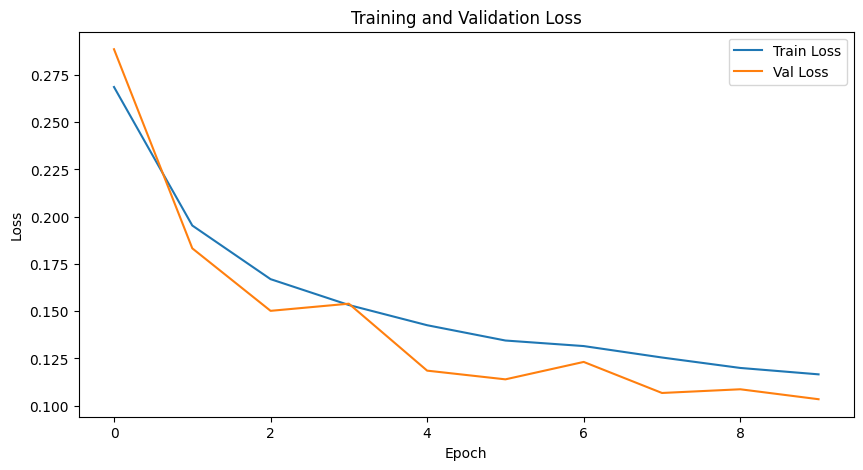

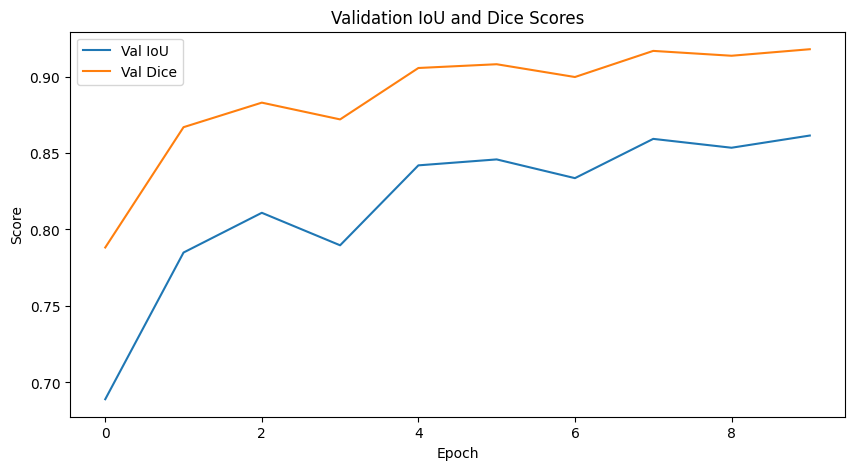

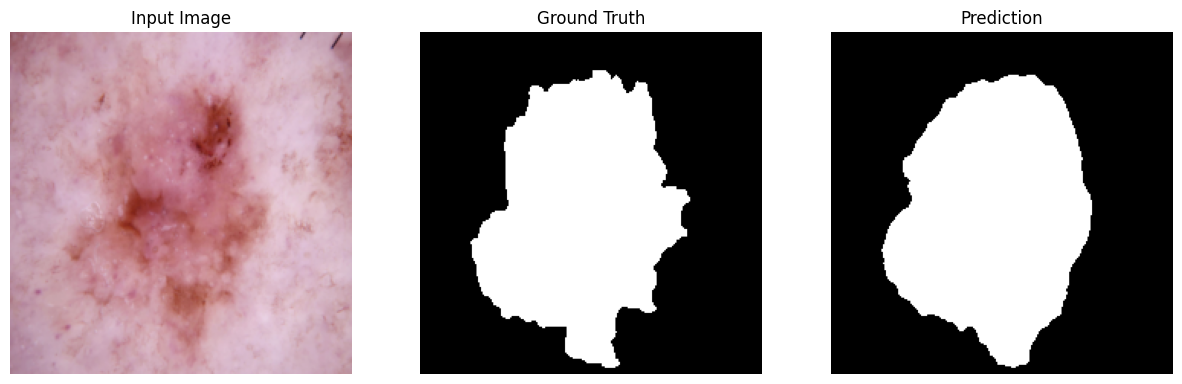

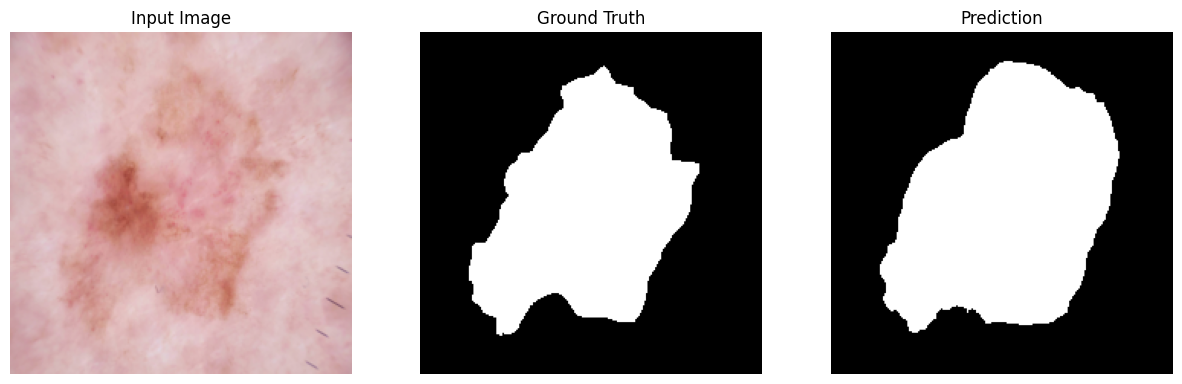

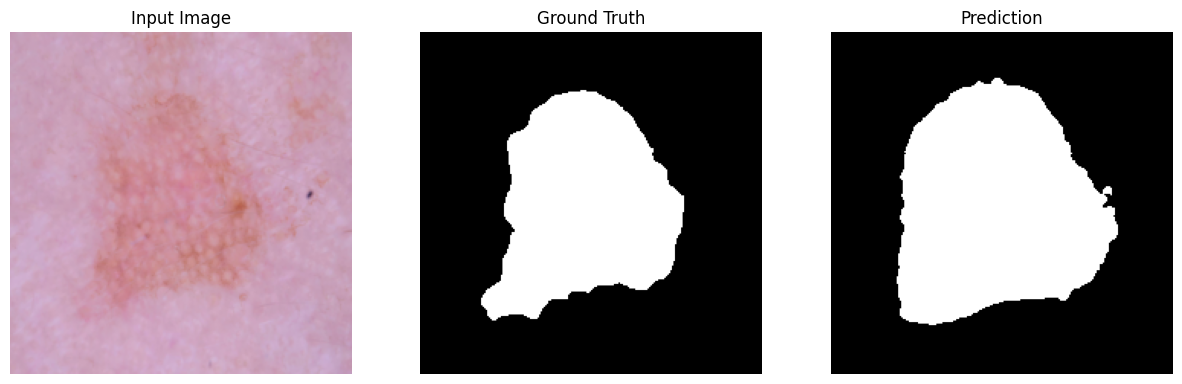

In [ ]:
# Initialize model
model = UNet(in_channels=3, out_channels=1).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
assert total_params < 60_000_000, "Model exceeds 60M parameters!"

# Define loss and metrics
criterion = nn.BCEWithLogitsLoss()

def iou_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def dice_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + 1e-6) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-6)
    return dice.mean().item()

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
val_ious = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  
        
        optimizer.zero_grad()
        outputs = model(images)  
        loss = criterion(outputs, masks)
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}")
            break
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_iou += iou_score(outputs, masks) * images.size(0)
            val_dice += dice_score(outputs, masks) * images.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)
    val_dice /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")

# Save model
torch.save(model.state_dict(), "unet_segmentation.pth")

# Evaluate on test set
model.eval()
test_iou = 0
test_dice = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_iou += iou_score(outputs, masks) * images.size(0)
        test_dice += dice_score(outputs, masks) * images.size(0)

test_iou /= len(test_loader.dataset)
test_dice /= len(test_loader.dataset)
print(f"Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}")

# Visualize results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_ious, label="Val IoU")
plt.plot(val_dices, label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.title("Validation IoU and Dice Scores")
plt.show()

# Visualize example segmentations
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()
    
    for i in range(min(3, images.size(0))):  # Show up to 3 examples
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].cpu().numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].cpu().numpy().squeeze(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
        plt.show()